In [1]:
# %matplotlib inline
%matplotlib notebook

try:
    from importlib import reload
except:
    pass

from __future__ import print_function ## Force python3-like printing

import os

from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import sfdmap

from astropy.table import Table,Column

In [2]:
import json
import pandas as pd
import numpy as np

import pycoco as pcc
import pyCoCo as pccsim

from astropy.cosmology import LambdaCDM
from scipy.interpolate import InterpolatedUnivariateSpline

import lsst_tools as lsstt
from lcsim.simlib import SIMLIBReader
from lcsim.lcsim import LCSim
from datetime import datetime

In [3]:
# verbose = True
verbose = False
log = True
# log = False
# logall = False
if log:
    gentime = str(datetime.now())
    logvars = ["gentime",
               "logpath",
#                "field_index",
#                "field",
#                "CCD_index",
               "z_sim",
               "MW_EBV",
               "mag_offset",
               "host_EBV",
               "mjdmax",
               "subtype",
               "w",
               "snindex",
               "snname",
               "flux",
               "n",
               "n_sne",
               ]

## Initialise pyCoCo    
fltPath = b"/Users/berto/Code/CoCo/data/filters"
rootPath = b"/Users/berto/Code/CoCo"
# rootPath = b"/Users/berto/projects/stunt_CoCo"

coco = pccsim.pyCoCo(fltPath, rootPath)
lcs = LCSim()



In [4]:
z_max = 0.301
## This is faster than choose_z_volume_SFR -
## choose_z_volume_SFR is faster to generate large numbers
binsize = 0.01
z = np.arange(0.0, z_max, binsize)
z_dz = np.arange(0.0 + binsize, z_max + binsize, binsize)

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

v_z = cosmo.comoving_volume(z)
v_z_dz = cosmo.comoving_volume(z_dz)

v_dz = v_z_dz - v_z

norm_v_dz = v_dz / np.nanmax(v_dz)

sfr_z = lsstt.sims.calculate_SFR(z)
sfr_norm = sfr_z / np.nanmax(sfr_z)

volumetric_rate = norm_v_dz * sfr_norm
normed_volumetric_rate = volumetric_rate / np.nanmax(volumetric_rate)
## Generate probability density function
pdf = InterpolatedUnivariateSpline(z, normed_volumetric_rate)

In [5]:
info = pcc.InfoClass()
info.load()

filter_names = ["SDSS_u","SDSS_g","SDSS_r","SDSS_i","SDSS_z"]

zp_dict = {}
for i in filter_names:
    zp_dict[i] = pcc.kcorr.calc_AB_zp(i)

n_sne = 0
n = 0

lc_outdir = "/Users/berto/projects/SDSS_sims/testing/z_evo/lcs/"
log_outdir = "/Users/berto/projects/SDSS_sims/testing/z_evo/logs/"

outfile = lc_outdir + "SN_"
logfile = log_outdir + "LOG_SN_"

In [6]:
mjd_list = np.arange(0.,101,1.0)-20
mjd_to_sim = np.array([])
filters_to_sim = []

for mjd in mjd_list:
    for filter_name in filter_names:
        filters_to_sim = np.append(filters_to_sim, lsstt.utils.b(filter_name))
        mjd_to_sim = np.append(mjd_to_sim, mjd)


In [7]:
# filters_to_sim
# mjd_to_sim
# len(mjd_to_sim)

In [41]:
verbose = True

## choose MWEBV
# MW_EBV = obslog.mwebv.mean()
MW_EBV = 0.05
if verbose: print(MW_EBV)

## Choose MagOffset
# mag_offset = np.random.choice(mag_offsets)
mag_offset = lsstt.sims.choose_magoffset(n=1)
if verbose: print("magoffset = ", mag_offset)

## Choose HostEBV
host_EBV = lsstt.sims.choose_extinction_host(n=1)
if verbose: print(MW_EBV)

## Choose MJDmax
# mjdmax = lsstt.sims.choose_MJDmax(obslog, n=1)
mjdmax = np.array([10])
if verbose: print(mjdmax)

## Choose SN Type
subtype = lsstt.sims.choose_subtype()
if verbose: print(subtype)

## Choose SN
w = np.where(info.table["Type"] == subtype)[0]
snindex = np.random.choice(w)
# snname = pcc.utils.b(info.table["snname"].data[w][0])
snname = pcc.utils.b("SN1994I")


if verbose: print(w, snname)

0.05
magoffset =  [ 0.42717895]
0.05
[10]
IIb
[ 0  2 16 17 24 25 26] b'SN1994I'


In [42]:
z_sim = 0.001
flux, flux_err = coco.simulate(b"SN1993J",
                               0.001, 0.0, 0.0, 0.0, 3.1,
                               mjdmax, mjd_to_sim,
                               filters_to_sim)

In [43]:
flux.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [44]:
print(mjdmax)
print(snname)

[10]
b'SN1994I'


In [45]:
z_sim = 0.001
specphot_ap_table = Table()
for filter_name in filter_names:
    specphot = coco.spec_photometry(snname, 
                     z_sim, lsstt.b(filter_name))
    specphot_ap_table 

In [46]:
specphot

array([[  2.59111000e+01,   3.38892000e+01,   5.58263000e+01,
          2.29256000e+01,   2.98552000e+00,   3.18922000e+01,
          2.39141000e+01,  -2.00699000e+00,   2.49126000e+01,
          2.19271000e+01,   3.28907000e+01,  -9.98502000e-03,
          1.98702000e+00,   3.98702000e+01,   2.79081000e+01,
          3.78732000e+01,   5.97104000e+00,  -4.99251000e+00,
          3.58862000e+01,   2.09286000e+01,   1.09536000e+01,
          9.88517000e-01,  -3.00549000e+00,   2.99051000e+01,
         -3.99401000e+00,   8.96655000e+00,   2.89066000e+01,
          5.48278000e+01,   3.68847000e+01,  -1.00849000e+00,
         -5.99101000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   6.03753219e-16,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.14887416e-14,
          0.00000000e+00,   0.00000000e+00,   2.97336431e-14,
          1.37571821e-14,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.25349651e-14,

<IPython.core.display.Javascript object>


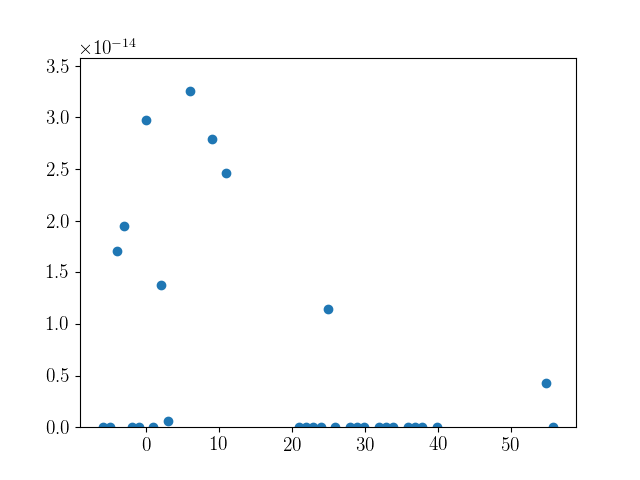

(0.0, 3.5788461628120655e-14)

In [47]:
plt.scatter(specphot[0], specphot[1])
plt.ylim(np.nanmin(specphot[1]), np.nanmax(specphot[1])*1.1)

In [54]:
print(np.vstack((specphot[0],specphot[1])).T)

[[  2.59111000e+01   0.00000000e+00]
 [  3.38892000e+01   0.00000000e+00]
 [  5.58263000e+01   0.00000000e+00]
 [  2.29256000e+01   0.00000000e+00]
 [  2.98552000e+00   6.03753219e-16]
 [  3.18922000e+01   0.00000000e+00]
 [  2.39141000e+01   0.00000000e+00]
 [ -2.00699000e+00   0.00000000e+00]
 [  2.49126000e+01   1.14887416e-14]
 [  2.19271000e+01   0.00000000e+00]
 [  3.28907000e+01   0.00000000e+00]
 [ -9.98502000e-03   2.97336431e-14]
 [  1.98702000e+00   1.37571821e-14]
 [  3.98702000e+01   0.00000000e+00]
 [  2.79081000e+01   0.00000000e+00]
 [  3.78732000e+01   0.00000000e+00]
 [  5.97104000e+00   3.25349651e-14]
 [ -4.99251000e+00   0.00000000e+00]
 [  3.58862000e+01   0.00000000e+00]
 [  2.09286000e+01   0.00000000e+00]
 [  1.09536000e+01   2.45777477e-14]
 [  9.88517000e-01   0.00000000e+00]
 [ -3.00549000e+00   1.95023484e-14]
 [  2.99051000e+01   0.00000000e+00]
 [ -3.99401000e+00   1.70342929e-14]
 [  8.96655000e+00   2.79436359e-14]
 [  2.89066000e+01   0.00000000e+00]
 

simulating  b'SN1993J' at z= 0.001


<IPython.core.display.Javascript object>


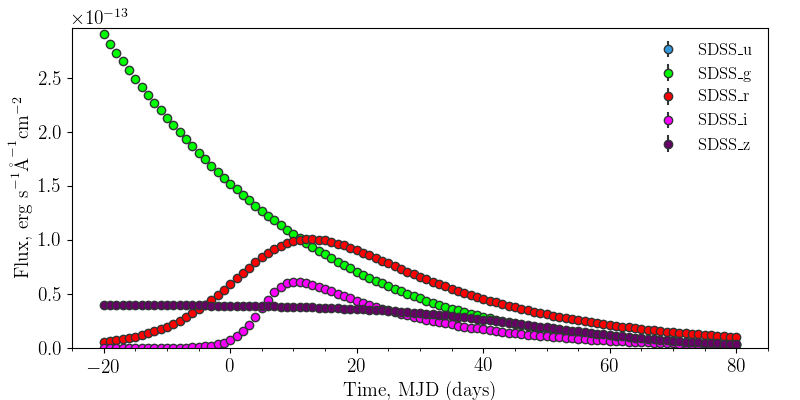

simulating  b'SN1993J' at z= 0.051


/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


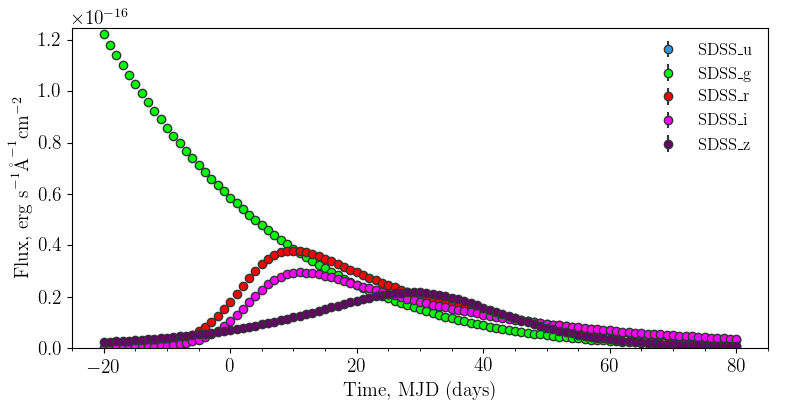

simulating  b'SN1993J' at z= 0.101


<IPython.core.display.Javascript object>


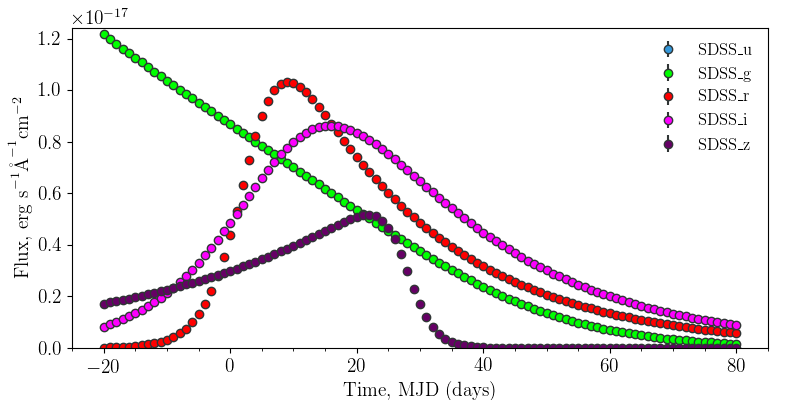

simulating  b'SN1993J' at z= 0.151


<IPython.core.display.Javascript object>


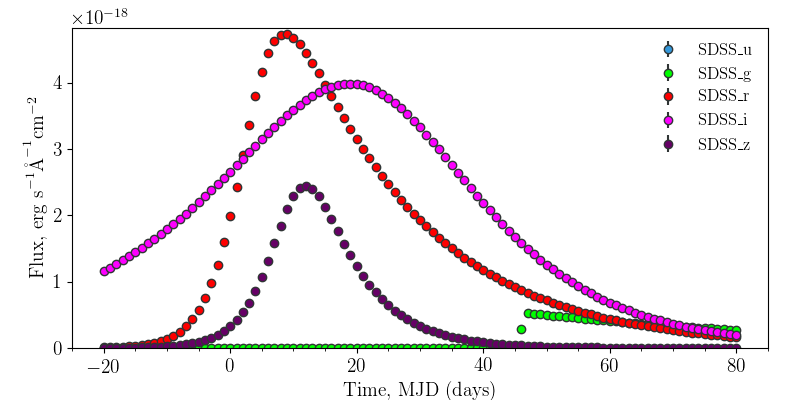

simulating  b'SN1993J' at z= 0.201


<IPython.core.display.Javascript object>


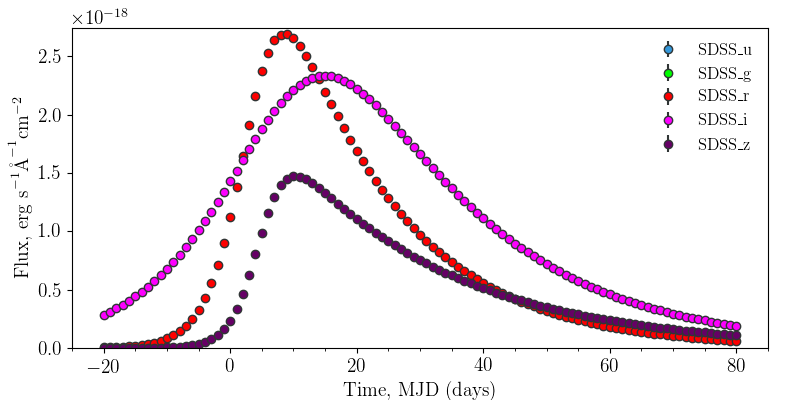

simulating  b'SN1993J' at z= 0.251


<IPython.core.display.Javascript object>


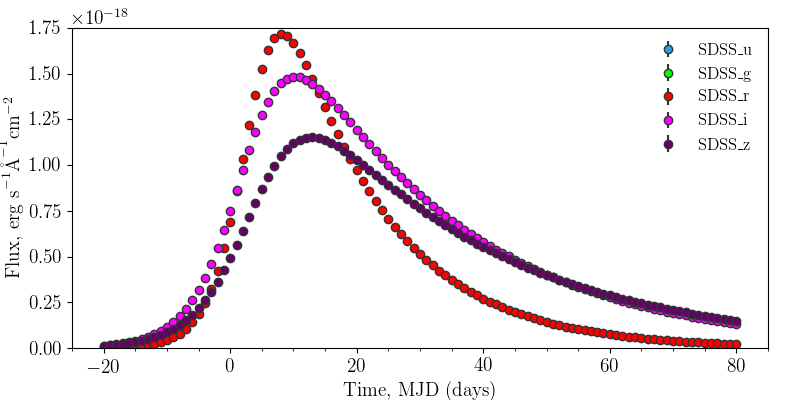

simulating  b'SN1993J' at z= 0.301


<IPython.core.display.Javascript object>


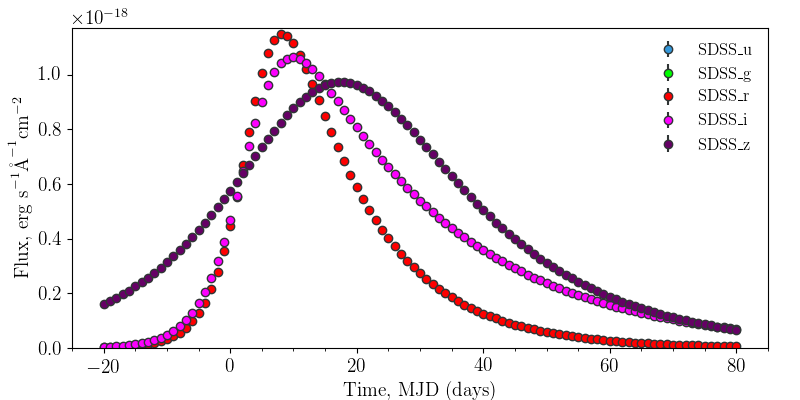

In [40]:
verbose = False
stepsize = 0.05
plot = True
for z_sim in np.arange(0.001, z_max+stepsize,stepsize):
    print("simulating " , snname, "at z=", z_sim)
    if log:
        logpath = logfile + str(n_sne+1).rjust(6, "0") +".json"

    # snname = b"SN2011dh"
    # mag_offset = -2.0 ## Make Ia-like
    ## Simulate "Perfect" LC
    flux, flux_err = coco.simulate(snname,
                                   z_sim, mag_offset, MW_EBV, host_EBV, 3.1,
                                   mjdmax, mjd_to_sim,
                                   filters_to_sim)
    #
    # flux, flux_err = coco.simulate(snname,
    #                                z_obs, 0.0, 0.0, 0.0, 3.1,
    #                                mjdmax, mjd_to_sim,
    #                                filters_to_sim)
#         print(flux)
    p = pcc.PhotometryClass()
    p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim), verbose=False)
    if plot: p.plot(enforce_zero=True)

    ## calculate zeropoints and convert to mag
    p_df = p.phot.to_pandas()
    p_df["zp"] = p_df["filter"].map(zp_dict)
    if verbose: print(p_df)
    p_df["mag"] = -2.5 * np.log10(p_df.flux) - p_df.zp

    ## Add noise - returns units of
#         flux, flux_err = lcs.simulate(p_df["mag"], obslog, unit="ab")
    flux = pd.Series(flux)
    flux_err = pd.Series(0.05*flux)

#     if plot:
#         plt.errorbar(p_df.MJD, flux, yerr=flux_err.values, fmt="o")
#         plt.show()

    w_detected = np.where((~np.isnan(flux.values)) & ((flux.values/flux_err.values) > 5))[0]
    # if verbose:
    if verbose:
        print("Flux, Flux_err")
        print(flux, flux_err)
    if verbose:
        print("where detected, len")
        print(w_detected, len(w_detected))


    if verbose: print("good sne")
    ## Remove redshift simulated at top of code from the list
    # z_obs = np.delete(z_obs, [w_z])

    p_df["flux"] = flux
    p_df["flux_err"] = flux_err
    p_df["#MJD"] = p_df["MJD"]
    p_df.fillna(0, inplace = True)
    full_out_path = outfile + str(z_sim).rjust(6, "0") + ".dat"
    p_df[["#MJD", "flux", "flux_err", "filter"]].to_csv(full_out_path, sep=" ", index = False, )

    if log:
        logdict = {}
        for i in logvars:
            if type(locals()[i]) == np.ndarray:
                logdict[i] = locals()[i].tolist()
            elif type(locals()[i]) == np.int64:
                logdict[i] = int(locals()[i])
            elif type(locals()[i]) == pd.Series:
                logdict[i] = locals()[i].to_json()
            elif type(locals()[i]) == bytes:
                logdict[i] = str(locals()[i], "utf-8")
            else:
                logdict[i] = locals()[i]

        with open(logpath, "w") as ofile:
            json.dumps(logdict, sort_keys=True,
                       indent=4, separators=(',', ': '))
            #     for i in logvars:
            json.dump(logdict, ofile, sort_keys=True,
                      indent=4, separators=(',', ': '))

        #         ofile.write(str(i) + " " + str(locals()[i]) + "\n")
            ofile.close()


In [13]:
flux_err.values

array([             nan,              nan,   9.90287757e-23,
         1.93692126e-22,   7.98394339e-21,              nan,
                    nan,   1.30983386e-22,   2.49689336e-22,
         8.55528198e-21,              nan,              nan,
         1.73244230e-22,   3.21840591e-22,   9.16539426e-21,
                    nan,              nan,   2.29131006e-22,
         4.14780446e-22,   9.81647027e-21,              nan,
                    nan,   3.03028846e-22,   5.34454449e-22,
         1.05107297e-20,              nan,              nan,
         4.00726820e-22,   6.88476391e-22,   1.12503994e-20,
                    nan,              nan,   5.29860942e-22,
         8.86572947e-22,   1.20376850e-20,              nan,
                    nan,   7.00491186e-22,   1.14112970e-21,
         1.28747358e-20,              nan,              nan,
         9.25847889e-22,   1.46784874e-21,   1.37636021e-20,
                    nan,              nan,   1.22328747e-21,
         1.88651828e-21,

In [14]:
-2.5 * np.log10(p_df.flux) - p_df.zp

/Users/berto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


0            inf
1            inf
2      30.402839
3      29.249499
4      24.843600
5            inf
6            inf
7      30.099202
8      28.973779
9      24.768558
10           inf
11           inf
12     29.795596
13     28.698177
14     24.693766
15           inf
16           inf
17     29.492033
18     28.422734
19     24.619255
20           inf
21           inf
22     29.188533
23     28.147503
24     24.545061
25           inf
26           inf
27     28.885122
28     27.872557
29     24.471224
         ...    
475          inf
476          inf
477    28.825747
478    25.894991
479    25.502105
480          inf
481          inf
482    28.909531
483    25.939550
484    25.557863
485          inf
486          inf
487    28.993315
488    25.984109
489    25.613630
490          inf
491          inf
492    29.077099
493    26.028668
494    25.669406
495          inf
496          inf
497    29.160883
498    26.073227
499    25.725189
500          inf
501          inf
502    29.2446

Load in an templates object 